# Eagle8 benchmarking
This notebook is only to run the benchmark on `eagle8`

In [1]:
using Revise
using CUDA
using Adapt
using Unitful
using Interpolations
using StaticArrays
import PhysicalConstants.CODATA2018: h, k_B, R_∞, c_0, m_e, m_u, e, ε_0, a_0
using BenchmarkTools
using PyPlot

using JLD2

using Vaf
using AtomicData

storage = "/mn/stornext/d10/data/chriskbl/" # Storage location

device!(0) # for eagle8

Precompiling Vaf
  ✓ OpenMPI_jll
  ✓ HDF5_jll
  ✓ AtomicData
  ✓ Transparency
  ✓ HDF5
  ✓ Vaf
  6 dependencies successfully precompiled in 13 seconds. 70 already precompiled.


CuDevice(0): Tesla V100S-PCIE-32GB

In [2]:
include("calc_line_gpu.jl")
include("gpu_incline.jl")
function Adapt.adapt_structure(to, atmos::Atmosphere1D)
Atmosphere1D(
    atmos.nx,
    atmos.ny,
    atmos.nz,
    adapt(to, atmos.z),
    adapt(to, atmos.temperature),
    adapt(to, atmos.velocity_z),
    adapt(to, atmos.electron_density),
    adapt(to, atmos.hydrogen1_density),
    adapt(to, atmos.proton_density)
)
end

function Adapt.adapt_structure(to, itp::ExtinctionItpNLTE)
ExtinctionItpNLTE(
    adapt(to, itp.σ_atoms),    
    adapt(to, itp.σ_hminus),   
    adapt(to, itp.σ_h2plus),   
    adapt(to, itp.σ_h_ff),
    itp.λ,
)
end


function Adapt.adapt_structure(to, line::AtomicLine)
AtomicLine(
    line.nλ,
    line.χup,
    line.χlo,
    line.gup,
    line.glo,
    line.Aul,
    line.Blu,
    line.Bul,
    line.λ0,
    line.f_value,
    line.mass,
    adapt(to, line.λ),
    line.PRD,
    line.Voigt,
    nothing,
    nothing,
    line.γ,
)
end


#Adapt.@adapt_structure AtomicLine  # with this, it will not pass correct Nothing type
Adapt.@adapt_structure Atmosphere1D
Adapt.@adapt_structure ExtinctionItpNLTE

In [3]:
HOME_PATH = "/uio/hume/student-u67/chriskbl"
include("int_from_pops_multi3d.jl")
# The atomosphere data
BASE_DIR = "/mn/stornext/u3/tiago/data/rhout/cb24bih/Halpha/s385/output"
HALF_DIR = "/mn/stornext/u3/tiago/data/cb24bih/multi3d"
mesh_file = joinpath(HALF_DIR, "mesh.cb24bih_s0385")
atmos_file = joinpath(HALF_DIR, "atm3d.cb24bih_s0385")
pops_file = joinpath(BASE_DIR, "out_pop")
ATOM_DIR = joinpath(HOME_PATH, ".julia/packages/AtomicData/Po3lP/data/atoms")
atom_file = joinpath(AtomicData.get_atom_dir(), "H_6.yaml")
atmos, h_pops = read_atmos_hpops_multi3d(mesh_file, atmos_file, pops_file)
atmos = read_atmos_rh("/mn/stornext/u3/tiago/data/cb24bih/bifrost_cb24bih_s385_half.ncdf")
bckgr_atoms = [
        "Al.yaml",
        "C.yaml",
        "Ca.yaml",
        "Fe.yaml",
        "H_6.yaml",
        "He.yaml",
        "KI.yaml",
        "Mg.yaml",
        "N.yaml",
        "Na.yaml",
        "NiI.yaml",
        "O.yaml",
        "S.yaml",
        "Si.yaml",
]
atom_files = [joinpath(AtomicData.get_atom_dir(), a) for a in bckgr_atoms]

h_atom = read_atom("/mn/stornext/u3/tiago/codes/rh-data/Atoms/yaml/H_6_multi.yaml")
my_line = h_atom.lines[5]
my_line_gpu = Adapt.adapt_structure(CuArray, my_line);
POPS_FILE = "/mn/stornext/u3/tiago/data/rhout/cb24bih/Halpha/s385/output/out_pop"
h_pops = read_pops_multi3d(POPS_FILE, 504, 504, 467, 6)
nl = permutedims(h_pops[:, :, :, 2], (3, 2, 1))
nu = permutedims(h_pops[:, :, :, 3], (3, 2, 1))

itp_cpu = get_σ_itp(atmos, my_line.λ0, atom_files)
atmos_gpu = Adapt.adapt_structure(CuArray, atmos)
#atmos1D_gpu = Adapt.adapt_structure(CuArray, atmos1D)
itp_gpu = Adapt.adapt_structure(CuArray{Float64}, itp_cpu)

const global_ndep = atmos.nz
const γ_mult = ustrip((h * c_0 / (4 * π)) |> u"J * nm")
const c_0u = ustrip(c_0)
const invSqrtPi = Float32(1. / sqrt(π));

my_line_gpu = Adapt.adapt_structure(CuArray, my_line)
nl_gpu = CuArray(nl)
nu_gpu = CuArray(nu);

## CPU Speed

In [9]:
function calc_line_cpu_single!(
    line::AtomicLine,
    atm::Atmosphere1D{3, T},
    n_up::AbstractArray{T, 3},
    n_lo::AbstractArray{T, 3},
    σ_itp::ExtinctionItpNLTE{<:Real},
    intensity::AbstractArray{T, 3},
) where T <: AbstractFloat
    nz = atm.nz
    ny = atm.ny
    nx = atm.nx
    γ_energy = γ_mult / line.λ0

    #p = ProgressMeter.Progress(atmos.nx; desc="Intensity ")
    
    for i in 1:nx
        int_tmp = @MVector zeros(Float32, global_ndep)
        α_c = @MVector zeros(Float32, global_ndep)
        α_line = @MVector zeros(Float32, global_ndep)
        S_cont = @MVector zeros(Float32, global_ndep)
        S_line = @MVector zeros(Float32, global_ndep)
        damp = @MVector zeros(Float32, global_ndep)
        ΔλD = @MVector zeros(Float32, global_ndep)
            
        for j in 1:ny
            # before wave loop, calculate
            for k in 1:nz
                α_c[k] = α_cont(
                    σ_itp,
                    atm.temperature[k, j, i],
                    atm.electron_density[k, j, i],
                    atm.hydrogen1_density[k, j, i],
                    atm.proton_density[k, j, i],
                )
                S_cont[k] = blackbody_λ(σ_itp.λ, atm.temperature[k, j, i])
                
                ΔλD[k] = doppler_width(line.λ0, line.mass, atm.temperature[k, j, i])
                γ = calc_broadening(
                    line.γ,
                    atm.temperature[k, j, i],
                    atm.electron_density[k, j, i],
                    atm.hydrogen1_density[k, j, i],
                )
                damp[k] = damping(γ, line.λ0, ΔλD[k]) 
                α_line[k] = γ_energy * (
                        n_lo[k, j, i] * line.Blu - n_up[k, j, i] * line.Bul) * 1f9  # to m^-1
                S_line[k] = γ_energy * n_up[k, j, i] * line.Aul * 1f-3 / α_line[k]   # to kW m^2 nm^-1
            end
            
            for (w, λ) in enumerate(line.λ)
                # Boundary condition
                v = (λ - line.λ0 + line.λ0 * atm.velocity_z[nz, j, i] / c_0u) / ΔλD[nz]
                profile = voigt_humlicek(damp[nz], abs(v)) / (sqrt(π) * ΔλD[nz])
                α_old = α_c[nz] + α_line[nz] * profile
                S_old = S_cont[nz]  # at depth, S_total = S_cont = B because of LTE
                int_tmp[nz] = S_old  # correct for line source function in LTE, CRD
                int_old = S_old
    
                # piecewise explicitly
                incr = -1 
                for k in nz-1:incr:1 
                    # calculate all of these, all of the time:
                    v = (λ - line.λ0 + line.λ0 * atm.velocity_z[k, j, i] / c_0u) / ΔλD[k]
                    profile = voigt_humlicek(damp[k], abs(v)) / ΔλD[k] * invSqrtPi
                    η = α_line[k] * profile / α_c[k]
                    
                    α_new = α_c[k] + α_line[k] * profile
                    S_new = (η * S_line[k] + S_cont[k]) / (1 + η)
                    
                    Δτ = abs(atm.z[k] - atm.z[k-incr]) * (α_new + α_old) / 2
                    ΔS = (S_old - S_new) / Δτ
                    w1, w2 = Muspel._w2(Δτ)
                    int_tmp[k] = (1 - w1)*int_tmp[k-incr] + w1*S_new + w2*ΔS
        
                    S_old = S_new
                    α_old = α_new
                    
                    intensity[j, i, w] = int_tmp[k]
                end
            end
        end
        #ProgressMeter.next!(p)
    end
    return nothing
end


calc_line_cpu_single! (generic function with 1 method)

In [7]:
intensity_cpu = zeros(Float32, (atmos.ny, atmos.nx, my_line.nλ));

In [ ]:
calc_line_cpu_single!(my_line, atmos, nu, nl, itp_cpu, intensity_cpu);

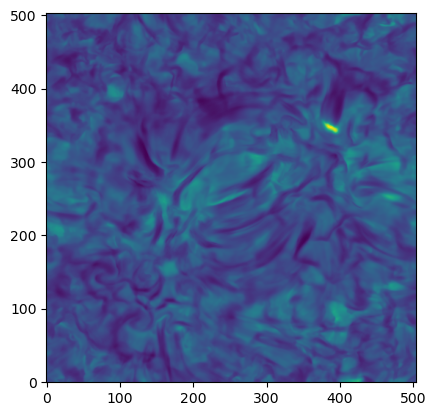

PyObject <matplotlib.image.AxesImage object at 0x7fc02a2f71f0>

In [13]:
imshow(intensity_cpu[:, :, 51])

In [8]:
@benchmark calc_line_cpu_single!(my_line, atmos, nu, nl, itp_cpu, intensity_cpu)

BenchmarkTools.Trial: 1 sample with 1 evaluation.
 Single result which took 693.734 s (0.00% GC) to evaluate,
 with a memory estimate of 2.93 MiB, over 1512 allocations.

In [10]:
function calc_line_cpu!(
    line::AtomicLine,
    atm::Atmosphere1D{3, T},
    n_up::AbstractArray{T, 3},
    n_lo::AbstractArray{T, 3},
    σ_itp::ExtinctionItpNLTE{<:Real},
    intensity::AbstractArray{T, 3},
) where T <: AbstractFloat
    nz = atm.nz
    ny = atm.ny
    nx = atm.nx
    γ_energy = γ_mult / line.λ0

    #p = ProgressMeter.Progress(atmos.nx; desc="Intensity ")
    
    Threads.@threads for i in 1:nx
        int_tmp = @MVector zeros(Float32, global_ndep)
        α_c = @MVector zeros(Float32, global_ndep)
        α_line = @MVector zeros(Float32, global_ndep)
        S_cont = @MVector zeros(Float32, global_ndep)
        S_line = @MVector zeros(Float32, global_ndep)
        damp = @MVector zeros(Float32, global_ndep)
        ΔλD = @MVector zeros(Float32, global_ndep)
            
        for j in 1:ny
            # before wave loop, calculate
            for k in 1:nz
                α_c[k] = α_cont(
                    σ_itp,
                    atm.temperature[k, j, i],
                    atm.electron_density[k, j, i],
                    atm.hydrogen1_density[k, j, i],
                    atm.proton_density[k, j, i],
                )
                S_cont[k] = blackbody_λ(σ_itp.λ, atm.temperature[k, j, i])
                
                ΔλD[k] = doppler_width(line.λ0, line.mass, atm.temperature[k, j, i])
                γ = calc_broadening(
                    line.γ,
                    atm.temperature[k, j, i],
                    atm.electron_density[k, j, i],
                    atm.hydrogen1_density[k, j, i],
                )
                damp[k] = damping(γ, line.λ0, ΔλD[k]) 
                α_line[k] = γ_energy * (
                        n_lo[k, j, i] * line.Blu - n_up[k, j, i] * line.Bul) * 1f9  # to m^-1
                S_line[k] = γ_energy * n_up[k, j, i] * line.Aul * 1f-3 / α_line[k]   # to kW m^2 nm^-1
            end
            
            for (w, λ) in enumerate(line.λ)
                # Boundary condition
                v = (λ - line.λ0 + line.λ0 * atm.velocity_z[nz, j, i] / c_0u) / ΔλD[nz]
                profile = voigt_humlicek(damp[nz], abs(v)) / (sqrt(π) * ΔλD[nz])
                α_old = α_c[nz] + α_line[nz] * profile
                S_old = S_cont[nz]  # at depth, S_total = S_cont = B because of LTE
                int_tmp[nz] = S_old  # correct for line source function in LTE, CRD
                int_old = S_old
    
                # piecewise explicitly
                incr = -1 
                for k in nz-1:incr:1 
                    # calculate all of these, all of the time:
                    v = (λ - line.λ0 + line.λ0 * atm.velocity_z[k, j, i] / c_0u) / ΔλD[k]
                    profile = voigt_humlicek(damp[k], abs(v)) / ΔλD[k] * invSqrtPi
                    η = α_line[k] * profile / α_c[k]
                    
                    α_new = α_c[k] + α_line[k] * profile
                    S_new = (η * S_line[k] + S_cont[k]) / (1 + η)
                    
                    Δτ = abs(atm.z[k] - atm.z[k-incr]) * (α_new + α_old) / 2
                    ΔS = (S_old - S_new) / Δτ
                    w1, w2 = Muspel._w2(Δτ)
                    int_tmp[k] = (1 - w1)*int_tmp[k-incr] + w1*S_new + w2*ΔS
        
                    S_old = S_new
                    α_old = α_new
                    
                    intensity[j, i, w] = int_tmp[k]
                end
            end
        end
        #ProgressMeter.next!(p)
    end
    return nothing
end


calc_line_cpu! (generic function with 1 method)

In [11]:
intensity = zeros(Float32, (atmos.ny, atmos.nx, my_line.nλ));

In [12]:
calc_line_cpu!(my_line, atmos, nu, nl, itp_cpu, intensity);

In [13]:
h5write("intensity_cpu.h5", "intensity", intensity)

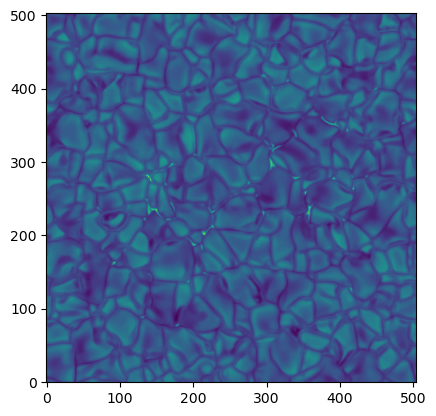

PyObject <matplotlib.image.AxesImage object at 0x7fc02412d000>

In [18]:
imshow(intensity[:, :, 1])

In [7]:
@benchmark calc_line_cpu!($my_line, $atmos, $nu, $nl, $itp_cpu, $intensity)

BenchmarkTools.Trial: 1 sample with 1 evaluation.
 Single result which took 11.036 s (0.00% GC) to evaluate,
 with a memory estimate of 3.00 MiB, over 1865 allocations.

## GPU Speed

In [4]:
intensity_gpu = CUDA.zeros(Float32, (atmos.ny, atmos.nx, my_line.nλ));

In [5]:
# eagle
CUDA.@sync @cuda threads=(8,8) blocks=(63,63) calc_line_gpu!(
    my_line_gpu, atmos_gpu, nu_gpu, nl_gpu, itp_gpu, intensity_gpu);

LoadError: MethodError: no method matching calc_line_gpu!(::AtomicLine{3, Float64, Int64, CuDeviceVector{Float64, 1}, Nothing}, ::Atmosphere3D{Float32, CuDeviceArray{Float32, 3, 1}, CuDeviceVector{Float32, 1}}, ::CuDeviceArray{Float32, 3, 1}, ::CuDeviceArray{Float32, 3, 1}, ::ExtinctionItpNLTE{Float64, Float64, Interpolations.Extrapolation{Float64, 2, ScaledInterpolation{Float64, 2, Interpolations.BSplineInterpolation{Float64, 2, OffsetArrays.OffsetMatrix{Float64, CuDeviceMatrix{Float64, 1}}, BSpline{Cubic{Line{OnGrid}}}, Tuple{Base.OneTo{Int64}, Base.OneTo{Int64}}}, BSpline{Cubic{Line{OnGrid}}}, Tuple{LinRange{Float64, Int64}, LinRange{Float64, Int64}}}, BSpline{Cubic{Line{OnGrid}}}, Line{Nothing}}, Interpolations.Extrapolation{Float64, 1, ScaledInterpolation{Float64, 1, Interpolations.BSplineInterpolation{Float64, 1, OffsetArrays.OffsetVector{Float64, CuDeviceVector{Float64, 1}}, BSpline{Cubic{Line{OnGrid}}}, Tuple{Base.OneTo{Int64}}}, BSpline{Cubic{Line{OnGrid}}}, Tuple{LinRange{Float64, Int64}}}, BSpline{Cubic{Line{OnGrid}}}, Line{Nothing}}}, ::CuDeviceArray{Float32, 3, 1})

[0mClosest candidates are:
[0m  calc_line_gpu!(::AtomicLine, [91m::Atmosphere1D{3, T, A, V} where {A<:AbstractArray{T, 3}, V<:AbstractVector{T}}[39m, ::AbstractArray{T, 3}, ::AbstractArray{T, 3}, ::ExtinctionItpNLTE{var"#s29", T2, ITP_2D, ITP_1D} where {var"#s29"<:Real, T2, ITP_2D<:(AbstractInterpolation{var"#s29", 2}), ITP_1D<:(AbstractInterpolation{var"#s29", 1})}, ::AbstractArray{T, 3}) where T<:AbstractFloat
[0m[90m   @[39m [32mMain[39m [90m/net/hume.uio.no/uio/hume/student-u67/chriskbl/Documents/master/Vaf.jl/scripts/[39m[90m[4mcalc_line_gpu.jl:112[24m[39m


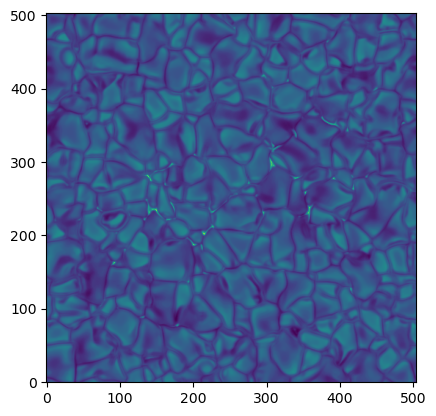

In [ ]:
intensity = Array(intensity_gpu)
imshow(intensity[:, :, 1])
gcf()

In [16]:
using HDF5
h5write("intensity_gpu.h5", "intensity", intensity)

In [17]:
CUDA.reclaim()

: 

In [10]:
fig, axs = subplots(1, 2)
axs[1].imshow(intensity[:, :, 1], cmap="gray")
axs[2].imshow(intensity[:, :, 51], cmap="gray")
savefig("intensity.pdf")

In [13]:
t_it = @benchmark CUDA.@sync @cuda threads=(8,8) blocks=(63,63) calc_line_gpu!(
    $my_line_gpu, $atmos_gpu, $nu_gpu, $nl_gpu, $itp_gpu, $intensity_gpu)

BenchmarkTools.Trial: 2 samples with 1 evaluation.
 Range (min … max):  2.518 s …    2.518 s  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     2.518 s               ┊ GC (median):    0.00%
 Time  (mean ± σ):   2.518 s ± 110.891 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █                                                        █  
  █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  2.52 s         Histogram: frequency by time         2.52 s <

 Memory estimate: 7.48 KiB, allocs estimate: 80.

: 

In [8]:
function benchmark_gpu(my_line, atmos, nu, nl, itp_cpu, intensity_gpu)
    my_line_gpu = Adapt.adapt_structure(CuArray, my_line)
    atmos_gpu = Adapt.adapt_structure(CuArray, atmos)
    itp_gpu = Adapt.adapt_structure(CuArray{Float32}, itp_cpu)
    nu_gpu = CuArray(nu)
    nl_gpu = CuArray(nl)
    
    @benchmark CUDA.@sync @cuda threads=(8,8) blocks=(63,63) calc_line_gpu!(
        my_line_gpu, atmos_gpu, nu_gpu, nl_gpu, itp_gpu, intensity_gpu)
end


benchmark_gpu (generic function with 1 method)

In [9]:
intensity_gpu = CUDA.zeros(Float32, (atmos.ny, atmos.nx, my_line.nλ))
@benchmark benchmark_gpu(my_line, atmos, nu, nl, itp_cpu, intensity_gpu)

BenchmarkTools.Trial: 1 sample with 1 evaluation.
 Single result which took 16.769 s (5.88% GC) to evaluate,
 with a memory estimate of 1.13 MiB, over 15835 allocations.

: 

## Comparison

For the single thread cpu version
```
BenchmarkTools.Trial: 1 sample with 1 evalueation.
    Single result which took 693.734 s (0.00% GC) to evaluate.
    with a memory estimate of 2.93 MiB, over 1512 allocations.
```

For the 16 thread cpu version
```
BenchmarkTools.Trial: 1 sample with 1 evalueation.
    Single result which took 44.105 s (0.00% GC) to evaluate.
    with a memory estimate of 1.61 MiB, over 1416 allocations.
```

For the 32 thread cpu version
```
BenchmarkTools.Trial: 1 sample with 1 evalueation.
    Single result which took 22.038 s (0.00% GC) to evaluate.
    with a memory estimate of 1.50 MiB, over 935 allocations.
```

For the 36 thread cpu version
```
BenchmarkTools.Trial: 1 sample with 1 evalueation.
    Single result which took 19.305 s (0.00% GC) to evaluate.
    with a memory estimate of 1.61 MiB, over 1416 allocations.
```

For the 64 thread cpu version
```
BenchmarkTools.Trial: 1 sample with 1 evalueation.
    Single result which took 11.036 s (0.00% GC) to evaluate.
    with a memory estimate of 1.61 MiB, over 1416 allocations.
```


For the 128 thread cpu version
```
BenchmarkTools.Trial: 1 sample with 1 evalueation.
    Single result which took 10.978 s (0.00% GC) to evaluate.
    with a memory estimate of 3.07 MiB, over 2269 allocations.
```

For the GPU version
```
BenchmarkTools.Trial: 1 sample with 1 evalueation.
    Single result which took 2.518 s (0.00% GC) to evaluate.
    with a memory estimate of 7.48 KiB, over 80 allocations.
```

For the GPU version with memory movement
```
BenchmarkTools.Trial: 1 sample with 1 evalueation.
    Single result which took 16.769 s (0.00% GC) to evaluate.
    with a memory estimate of 7.48 KiB, over 80 allocations.
```


In [25]:
gpu_time = 3.376
cpu_time_single_thread = 746.513
cpu_time_32_thread = 23.835

23.835

Speedup one thread

In [26]:
println("Lower: ", cpu_time_single_thread / gpu_time)
println("Higher: ", cpu_time_single_thread / gpu_time)

Lower: 220.60076832151302
Higher: 221.5829623033541


Speedup 32 thread

In [27]:
println("Lower: ", cpu_time_32_thread / gpu_time)
println("Higher: ", cpu_time_32_thread / gpu_time)

Lower: 7.043439716312057
Higher: 7.07479964381122


# The Watt usage. 
### CPU: 
* [AMD EPYC2 7742](https://www.amd.com/en/products/cpu/amd-epyc-7742)
* Max. boost clock: 3.4GHz
* Default TDP: 225W


### GPU:
* [NVIDIA Tesla V100S](https://images.nvidia.com/content/tesla/pdf/Tesla-V100-PCIe-Product-Brief.pdf)
* Total board power: 250 W

Assume that both are running at maximum to get the upperbound limit

In [30]:
GPU_watt = 250 
CPU_watt = 225

GPU_energy = GPU_watt * gpu_time
CPU_energy_single_thread = CPU_watt * cpu_time_single_thread
CPU_energy_32_thread = CPU_watt * cpu_time_32_thread;

In [31]:
println("Single thread: ", CPU_energy_single_thread / GPU_energy)
println("32 thread: ", CPU_energy_32_thread / GPU_energy)

Single thread: 199.0111670616114
32 thread: 6.354117298578199
